## Using embeddings trained from stack overflow data
[source](https://github.com/vefstathiou/SO_word2vec)

In [1]:
%run "Models training helpers.ipynb" sort=False

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
from gensim.models.keyedvectors import KeyedVectors
SO_embeddings = KeyedVectors.load_word2vec_format("Data/SO_vectors_200.bin", binary=True)

In [4]:
SO_embeddings.similarity('computer', 'pc')

0.86835635

In [5]:
'computer' in SO_embeddings

True

In [36]:
CONVENTION = "Industrial"
CONVENTION_LOWER = CONVENTION.lower()
EMBEDDING_DIM=200
NUM_EPOCHS=20

In [37]:
training_df = read_training_data()
df = training_df[training_df['convention'] == CONVENTION]

In [38]:
### Ading more green examples
green_audit_df = pd.read_csv("Data/Iterative-models-building/Classification results/Conventions/Audited/audited_ALL_2019-10-08-20:23:58.598102.tsv", sep="\t")
green_audit_df = green_audit_df[['text', 'provenance', 'convention', 'new']]
green_audit_df = green_audit_df.rename(columns={"new": "label"})
green_audit_df = green_audit_df[green_audit_df['convention']==CONVENTION_LOWER]
green_audit_df['convention'] = CONVENTION
green_audit_df.head(5)

,text,provenance,convention,label
0,The parser generates events similar to an xml ...,efficiency,Industrial,1
1,Verify response time of the Application Under ...,efficiency,Industrial,1
2,"Flexible and powerful JSON manipulation, valid...",efficiency,Industrial,1
3,"Requires data to be entered only once, with no...",efficiency,Industrial,1
4,DebugBear - Monitor website performance and Li...,efficiency,Industrial,1


In [39]:
df = pd.concat([df, green_audit_df])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [40]:
## Training a deep learning model given training, validation data
def train_DL_model(x_train, y_train, x_val, y_val, tokenizer, num_epochs=NUM_EPOCHS):
    
    word_index = tokenizer.word_index
    
    print('\nNumber of elements from each class in traing and validation set ')
    print(y_train.sum(axis=0))
    print(y_val.sum(axis=0))


    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        if word in SO_embeddings:
            
            embedding_vector = SO_embeddings[word]#embeddings_index.get(word)
        else:
            embedding_vector = None
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    

    convs = []
    filter_sizes = [3,4,5]

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    for fsz in filter_sizes:
        l_conv = Conv1D(nb_filter=128,filter_length=fsz,activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(5)(l_conv)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)#
    
    l_cov1= Conv1D(128, 5, activation='relu')(l_merge)
    l_pool1 = MaxPooling1D(5)(l_cov1)

    l_flat = Flatten()(l_pool1)
    l_dense = Dense(128, activation='relu')(l_flat)
    preds = Dense(2, activation='softmax')(l_dense)
    """
    l_cov1= Conv1D(128, 5, activation='relu')(l_merge)
    l_pool1 = MaxPooling1D(5)(l_cov1)
    l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)

    l_flat = Flatten()(l_cov2)
    
    l_dense = Dense(128, activation='relu')(l_flat)
    preds = Dense(2, activation='softmax')
    """
    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

    
    print("model fitting - more complex convolutional neural network")
    model.summary()
    train_history = model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=num_epochs, batch_size=50, callbacks=[roc_callback(validation_data=(x_val, y_val))])

    return model,tokenizer,x_val,y_val, train_history

In [41]:
conv_models = train_DL_models(df,
            data_class_column="convention", 
            data_label_column="label",
            df_val=None,
            tokenizer=extended_tokenizer,
            random_seed=0, 
            use_validation=True, num_epochs=NUM_EPOCHS)

Found 86029 unique tokens.
----------------------------------------------------------------
            Industrial                  
----------------------------------------------------------------
Shape of data tensor: (1812, 40)
Shape of label tensor: (1812, 2)

Number of elements from each class in traing and validation set 
[912. 538.]
[229. 133.]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 40, 200)      17206000    input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 38, 128)      76928       embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 37, 128)      102528      embedding_5[0][0]                
__________________________________

In [42]:
accs = conv_models[4][CONVENTION].history['acc']
val_accs = conv_models[4][CONVENTION].history['val_acc']

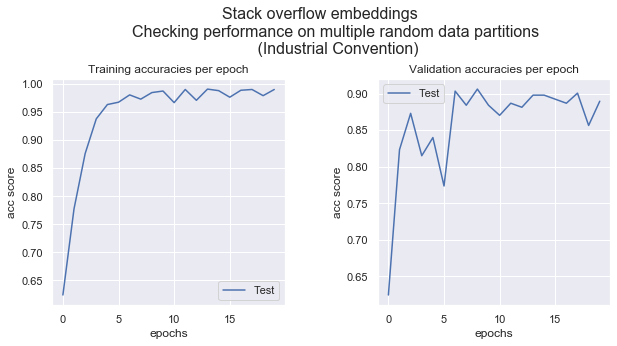

In [43]:
epochs=np.arange(0,NUM_EPOCHS,1)

fig = plt.figure(figsize=[10,10])
fig.suptitle("Stack overflow embeddings \n      Checking performance on multiple random data partitions\n       ({} Convention)".format(CONVENTION), fontsize=16)
plt.subplot(2, 2, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)


plt.plot(epochs,accs, label="Test")
plt.title("Training accuracies per epoch")
plt.xlabel("epochs")
plt.ylabel("acc score")
plt.legend()

plt.subplot(2, 2, 2)

plt.plot(epochs,val_accs, label="Test")
plt.title("Validation accuracies per epoch")
plt.xlabel("epochs")
plt.ylabel("acc score")
plt.legend()
plt.show()


In [44]:
NUM_SENTENCES_TO_SHOW=20

df_test = pd.read_csv(os.path.join(GATHERED_DATA_FOLDER, "gathered_github_sentences.tsv"), sep="\t")

test_sentences = df_test['sentence'].values
test_sentences = np.array([sent for sent in test_sentences if len(sent.split(" "))<40])

test_seq = extended_tokenizer.texts_to_sequences(test_sentences)
test_seq = pad_sequences(test_seq, maxlen=MAX_SEQUENCE_LENGTH)

preds = conv_models[0][CONVENTION].predict(test_seq)[:,1]

print("-----------------------------------------------------")
print(" >> DL model results")
print(" >> Top sentences with higher confidence for Github:")
print("            ({} convention)".format(CONVENTION))
print("-----------------------------------------------------\n")
for s in test_sentences[preds.argsort()[-NUM_SENTENCES_TO_SHOW:][::-1]]:
    print("{}\n".format(s))

-----------------------------------------------------
 >> DL model results
 >> Top sentences with higher confidence for Github:
            (Industrial convention)
-----------------------------------------------------

surprisingly threading and debugging introduces nearlyno overhead.statethis project is still in an alpha state.

pca decomposition 2d projection of the data based on classes.

the project achieves roughly 0.65 roc auc score using logistic regression and neural networks.

sense data science development platform a new cloud platform for data science and big data analyticscollaborate on, scale, and deploy data analysis and advanced analytics projects radically faster.

deepspeech.py train files .. data cv en clips train.csv dev files .. data cv en clips dev.csv test files .. data cv en clips test.csv training a modelthe central python script is deepspeech.py in the project s root directory.

mxfusion - modular probabilistic programming on mxnet sklearn-crfsuite - a scikit-l